In [17]:
import json
import zipfile

from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

In [18]:
pd.options.mode.copy_on_write = True

In [19]:
ASSETS_DIR = '../assets'

In [20]:
cols = ['genres', 'imdb_id', 'overview', 'release_date', 'title']
df = pd.read_csv(f'{ASSETS_DIR}/movie_metadata.csv', usecols=cols)

In [23]:
df = df.dropna(subset=['imdb_id', 'title'])

df['imdb_id'] = df['imdb_id'].str.lstrip('t').astype(int)
df = df.set_index('imdb_id')
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce', format='%Y-%m-%d')

def deserialize_genres(genres: str) -> list:
    return [g['name'] for g in json.loads(genres.replace("'", '"')) if 'name' in g] or None

df['genres'] = df['genres'].apply(deserialize_genres)

df = df.rename(columns={'overview': 'plot'})[['title', 'release_date', 'genres', 'plot']]
df

,title,release_date,genres,plot
imdb_id,,,,
114709,Toy Story,1995-10-30,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ..."
113497,Jumanji,1995-12-15,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...
113228,Grumpier Old Men,1995-12-22,"[Romance, Comedy]",A family wedding reignites the ancient feud be...
114885,Waiting to Exhale,1995-12-22,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom..."
113041,Father of the Bride Part II,1995-02-10,[Comedy],Just when George Banks has recovered from his ...
...,...,...,...,...
6209470,Subdue,NaT,"[Drama, Family]",Rising and falling between a man and woman.
2028550,Century of Birthing,2011-11-17,[Drama],An artist struggles to finish his work while a...
303758,Betrayal,2003-08-01,"[Action, Drama, Thriller]","When one of her hits goes wrong, a professiona..."


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45443 entries, 114709 to 6980792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         45443 non-null  object        
 1   release_date  45362 non-null  datetime64[ns]
 2   genres        43006 non-null  object        
 3   plot          44491 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.7+ MB


In [25]:
df_poster = pd.read_csv(f'{ASSETS_DIR}/movie_links.csv',
                        index_col='imdbId', usecols=['imdbId', 'movieId'])
df_poster.index = df_poster.index.rename('imdb_id')
df_poster = df_poster.rename(columns={'movieId': 'poster_id'})

In [26]:
poster_archive = zipfile.ZipFile(f'{ASSETS_DIR}/movie_posters.zip', 'r')
poster_names = {name: None for name in poster_archive.namelist()}

def extract_poster(id: int):
    filename = f'MLP-20M/MLP-20M/{id}.jpg'
    return poster_archive.read(filename) if filename in poster_names else None

df_poster['data'] = df_poster['poster_id'].apply(extract_poster)
df_poster

,poster_id,data
imdb_id,,
114709,1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
113497,2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
113228,3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
114885,4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
113041,5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...
466713,131254,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
277703,131256,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3485166,131258,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [27]:
df_poster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27278 entries, 114709 to 1724965
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   poster_id  27278 non-null  int64 
 1   data       26938 non-null  object
dtypes: int64(1), object(1)
memory usage: 639.3+ KB


In [33]:
df = df.join(df_poster[['data']], sort=True).rename(columns={'data': 'poster'})
df

,title,release_date,genres,plot,poster
imdb_id,,,,,
1,Carmencita,1894-03-14,[Documentary],The first woman to appear in front of an Ediso...,NaN
3,Poor Pierrot,1892-10-28,"[Comedy, Animation]","One night, Arlequin come to see his lover Colo...",NaN
5,Blacksmith Scene,1893-05-08,[Drama],Three men hammer on an anvil and pass a bottle...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
8,Edison Kinetoscopic Record of a Sneeze,1894-01-09,[Documentary],A man (Thomas Edison's assistant) takes a pinc...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
10,Workers Leaving the Lumière Factory,1895-06-10,[Documentary],Working men and women leave the Lumière factor...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...,...,...
7068896,Chris D'Elia: Man on Fire,2017-06-27,[Comedy],Unbridled comic Chris D'Elia reconsiders his a...,NaN
7078780,Zygote,2017-07-12,"[Horror, Science Fiction]","Stranded in an Arctic mine, two survivors are ...",NaN
7078926,Firebase,2017-06-28,"[Action, Science Fiction, War]","Set during the Vietnam war, Firebase follows A...",NaN


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45443 entries, 1 to 7158814
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         45443 non-null  object        
 1   release_date  45362 non-null  datetime64[ns]
 2   genres        43006 non-null  object        
 3   plot          44491 non-null  object        
 4   poster        26753 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.1+ MB


In [35]:
df.to_pickle(f'{ASSETS_DIR}/movies.pkl.zst', compression='zstd')

In [36]:
df = pd.read_pickle(f'{ASSETS_DIR}/movies.pkl.zst', compression='zstd')
df

,title,release_date,genres,plot,poster
imdb_id,,,,,
1,Carmencita,1894-03-14,[Documentary],The first woman to appear in front of an Ediso...,NaN
3,Poor Pierrot,1892-10-28,"[Comedy, Animation]","One night, Arlequin come to see his lover Colo...",NaN
5,Blacksmith Scene,1893-05-08,[Drama],Three men hammer on an anvil and pass a bottle...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
8,Edison Kinetoscopic Record of a Sneeze,1894-01-09,[Documentary],A man (Thomas Edison's assistant) takes a pinc...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
10,Workers Leaving the Lumière Factory,1895-06-10,[Documentary],Working men and women leave the Lumière factor...,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...,...,...
7068896,Chris D'Elia: Man on Fire,2017-06-27,[Comedy],Unbridled comic Chris D'Elia reconsiders his a...,NaN
7078780,Zygote,2017-07-12,"[Horror, Science Fiction]","Stranded in an Arctic mine, two survivors are ...",NaN
7078926,Firebase,2017-06-28,"[Action, Science Fiction, War]","Set during the Vietnam war, Firebase follows A...",NaN


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45443 entries, 1 to 7158814
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         45443 non-null  object        
 1   release_date  45362 non-null  datetime64[ns]
 2   genres        43006 non-null  object        
 3   plot          44491 non-null  object        
 4   poster        26753 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 2.1+ MB


In [38]:
def plot_poster(poster_data):
    img = np.array(Image.open(BytesIO(poster_data)))
    plt.imshow(img)
    plt.axis('off')

In [51]:
jumanji = df[df['title'] == 'Jumanji'].iloc[0]
jumanji

title                                                     Jumanji
release_date                                  1995-12-15 00:00:00
genres                               [Adventure, Fantasy, Family]
plot            When siblings Judy and Peter discover an encha...
poster          b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
Name: 113497, dtype: object

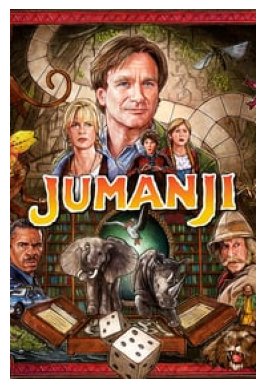

In [52]:
plot_poster(jumanji['poster'])